<a href="https://colab.research.google.com/github/luthfiarifin/Hybrid-RViT-Car-Retrieval/blob/main/2_train_the_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [6]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
)
import time
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
CUDA memory: 14.7 GB


=== Dataset Exploration ===

Training set:
  hatchback: 1921 images
  mpv: 2609 images
  offroad: 892 images
  pickup: 1039 images
  sedan: 2429 images
  suv: 3184 images
  truck: 414 images
  van: 895 images
  Total training images: 13383

Validation set:
  hatchback: 240 images
  mpv: 326 images
  offroad: 111 images
  pickup: 130 images
  sedan: 304 images
  suv: 398 images
  truck: 52 images
  van: 112 images
  Total validation images: 1673


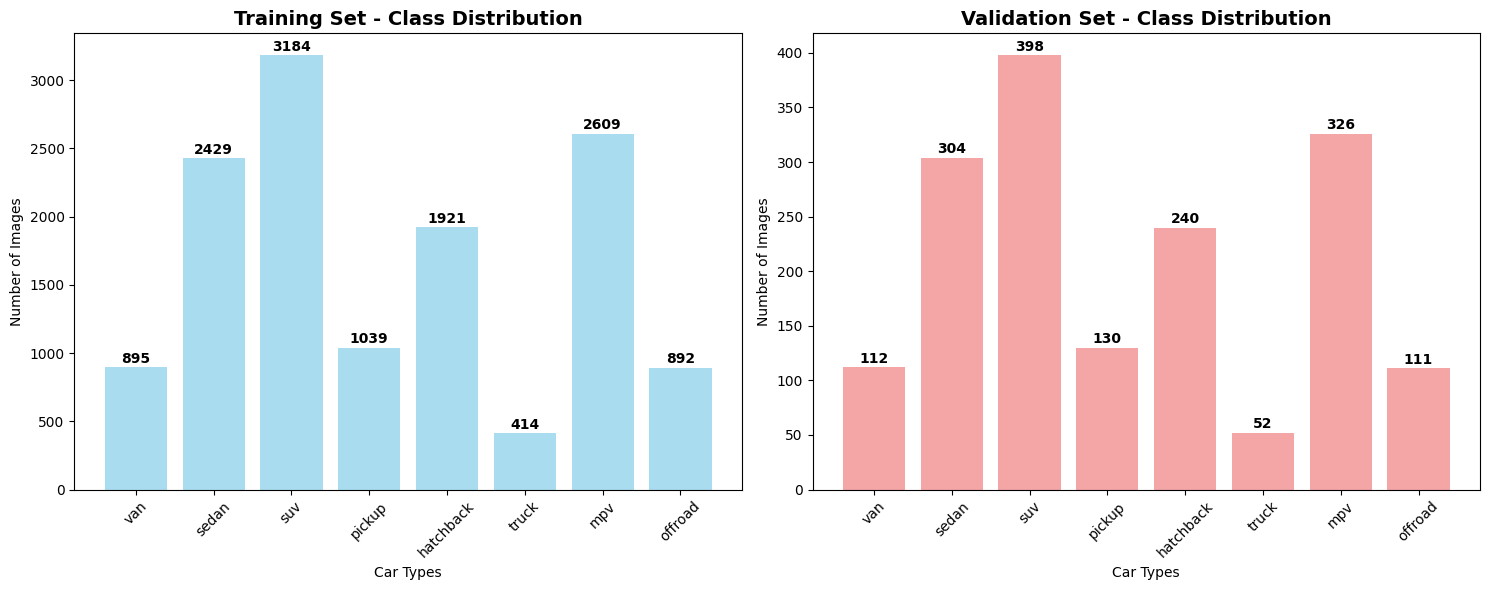


=== Dataset Summary ===
    Class  Training  Validation  Total  Train_Ratio
      van       895         112   1007        0.889
    sedan      2429         304   2733        0.889
      suv      3184         398   3582        0.889
   pickup      1039         130   1169        0.889
hatchback      1921         240   2161        0.889
    truck       414          52    466        0.888
      mpv      2609         326   2935        0.889
  offroad       892         111   1003        0.889


In [7]:
# Dataset exploration
def explore_dataset(data_dir):
    """Explore the dataset structure and class distribution"""
    if not os.path.exists(data_dir):
        print(f"Dataset directory {data_dir} not found!")
        return None

    # Get class names and counts
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len(
                [
                    f
                    for f in os.listdir(class_path)
                    if f.lower().endswith((".jpg", ".jpeg", ".png"))
                ]
            )
            class_counts[class_name] = count

    return class_counts


# Explore training and validation datasets
train_data_dir = "data_processing/data/dataset/train"
val_data_dir = "data_processing/data/dataset/val"

print("=== Dataset Exploration ===")
train_counts = explore_dataset(train_data_dir)
val_counts = explore_dataset(val_data_dir)

if train_counts:
    print(f"\nTraining set:")
    for class_name, count in sorted(train_counts.items()):
        print(f"  {class_name}: {count} images")
    print(f"  Total training images: {sum(train_counts.values())}")

if val_counts:
    print(f"\nValidation set:")
    for class_name, count in sorted(val_counts.items()):
        print(f"  {class_name}: {count} images")
    print(f"  Total validation images: {sum(val_counts.values())}")

# Visualize class distribution
if train_counts and val_counts:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Training set distribution
    classes = list(train_counts.keys())
    train_values = list(train_counts.values())
    ax1.bar(classes, train_values, color="skyblue", alpha=0.7)
    ax1.set_title("Training Set - Class Distribution", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Car Types")
    ax1.set_ylabel("Number of Images")
    ax1.tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(train_values):
        ax1.text(
            i, v + max(train_values) * 0.01, str(v), ha="center", fontweight="bold"
        )

    # Validation set distribution
    val_values = [val_counts.get(cls, 0) for cls in classes]
    ax2.bar(classes, val_values, color="lightcoral", alpha=0.7)
    ax2.set_title("Validation Set - Class Distribution", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Car Types")
    ax2.set_ylabel("Number of Images")
    ax2.tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(val_values):
        ax2.text(i, v + max(val_values) * 0.01, str(v), ha="center", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Create a summary dataframe
    df_summary = pd.DataFrame(
        {
            "Class": classes,
            "Training": train_values,
            "Validation": val_values,
            "Total": [train_values[i] + val_values[i] for i in range(len(classes))],
            "Train_Ratio": [
                train_values[i] / (train_values[i] + val_values[i])
                for i in range(len(classes))
            ],
        }
    )
    df_summary["Train_Ratio"] = df_summary["Train_Ratio"].round(3)
    print("\n=== Dataset Summary ===")
    print(df_summary.to_string(index=False))

In [8]:
# Training configuration with class imbalance handling

from models.classification.train_classification import CarClassifierTrainer

CONFIG = {
    "train_dir": train_data_dir,
    "val_dir": val_data_dir,
    "num_classes": 8,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 6,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 20,
    "result_path": f'models/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
}

print("=== Training Configuration ===")
for key, value in CONFIG.items():
    print(f"{key}: {value}")

print(f"\n🎯 Class Imbalance Strategy:")
if CONFIG["use_weighted_loss"]:
    print("   ✅ Using Weighted CrossEntropyLoss (Recommended)")
    print("   - Automatically calculates inverse frequency weights")
    print("   - Gives higher importance to minority classes (truck, van, offroad)")
if CONFIG["use_class_balancing"]:
    print("   ✅ Using WeightedRandomSampler")
    print("   - Oversamples minority classes during training")

# Initialize the trainer with class imbalance handling
print("\n=== Initializing Trainer with Class Imbalance Handling ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    num_layers=CONFIG["num_layers"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

=== Training Configuration ===
train_dir: data_processing/data/dataset/train
val_dir: data_processing/data/dataset/val
num_classes: 8
embed_dim: 768
num_heads: 12
num_layers: 6
dropout: 0.1
learning_rate: 0.0001
batch_size: 64
num_epochs: 20
result_path: /content/drive/MyDrive/Hybrid-RViT-Car-Retrieval/carvit_model_20250622_001103.pth
use_weighted_loss: True
use_class_balancing: False
num_workers: 8

🎯 Class Imbalance Strategy:
   ✅ Using Weighted CrossEntropyLoss (Recommended)
   - Automatically calculates inverse frequency weights
   - Gives higher importance to minority classes (truck, van, offroad)

=== Initializing Trainer with Class Imbalance Handling ===
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Using weighted CrossEntropyLoss with weights: tensor([0.8708, 0.6412, 1.8754, 1.6101, 0.6887, 0.5254, 4.0408, 1.8691],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
hatchback    1921     14.4      % 1.66           x
mpv          2609     19.5      % 1.22           x
offroad      892      6.7       % 3.57           x
pickup       1039     7.8       % 3.06           x
sedan        2429     18.1      % 1.31           x
suv          3184     23.8      % 1.00           x
truck        414      3.1       % 7.69           x
van          895      6.7       % 3.56           x

📈 Imbalance Factor: 7.69x (Most frequent / Least frequent)
⚠️  High imbalance detected! Consider using weighted loss or resampling.
Trainer initialized successfully!
Training samples: 13383
Validation samples: 1673
Number of batches per epoch: 210
Class names: ['hatchback', 'mpv', 'offroad', 'pickup', 'sedan', 'suv

In [9]:
# Start training with detailed tracking
print("🚀 Starting model training...")
start_time = time.time()

# Execute training
training_results = trainer.train()

total_time = time.time() - start_time
print(f"\n🎉 Training completed in {total_time/60:.2f} minutes!")
print(f"📊 Training Results Summary:")
print(f"- Best Validation Accuracy: {training_results['best_accuracy']:.2f}%")
print(f"- Final Training Loss: {training_results['train_losses'][-1]:.4f}")
print(f"- Final Validation Loss: {training_results['val_losses'][-1]:.4f}")
print(f"- Average Time per Epoch: {np.mean(training_results['epoch_times']):.2f}s")

🚀 Starting model training...
Starting training with detailed tracking...
Model parameters: 143,116,360
Trainable parameters: 143,116,360

Epoch 1/20


100%|██████████| 210/210 [03:50<00:00,  1.10s/it, loss=0.307]


Validation accuracy: 75.37%
Validation loss: 0.6716
Time: 239.64s | LR: 1.00e-04
🎉 New best accuracy: 75.37%

Epoch 2/20


100%|██████████| 210/210 [03:47<00:00,  1.08s/it, loss=0.195]


Validation accuracy: 83.62%
Validation loss: 0.5394
Time: 236.15s | LR: 1.00e-04
🎉 New best accuracy: 83.62%

Epoch 3/20


100%|██████████| 210/210 [03:46<00:00,  1.08s/it, loss=0.565]


Validation accuracy: 87.03%
Validation loss: 0.4456
Time: 235.28s | LR: 1.00e-04
🎉 New best accuracy: 87.03%

Epoch 4/20


100%|██████████| 210/210 [03:46<00:00,  1.08s/it, loss=0.0515]


Validation accuracy: 85.65%
Validation loss: 0.5294
Time: 235.21s | LR: 1.00e-04

Epoch 5/20


100%|██████████| 210/210 [03:46<00:00,  1.08s/it, loss=0.0068]


Validation accuracy: 86.97%
Validation loss: 0.4807
Time: 235.18s | LR: 1.00e-04

Epoch 6/20


100%|██████████| 210/210 [03:45<00:00,  1.07s/it, loss=0.69]


Validation accuracy: 85.48%
Validation loss: 0.5662
Time: 234.49s | LR: 1.00e-04

Epoch 7/20


100%|██████████| 210/210 [03:45<00:00,  1.07s/it, loss=0.0634]


Validation accuracy: 86.97%
Validation loss: 0.5067
Time: 234.65s | LR: 1.00e-04

Epoch 8/20


100%|██████████| 210/210 [03:44<00:00,  1.07s/it, loss=0.151]


Validation accuracy: 88.22%
Validation loss: 0.4101
Time: 234.09s | LR: 1.00e-04
🎉 New best accuracy: 88.22%

Epoch 9/20


100%|██████████| 210/210 [03:45<00:00,  1.07s/it, loss=0.301]


Validation accuracy: 90.14%
Validation loss: 0.4791
Time: 234.45s | LR: 1.00e-04
🎉 New best accuracy: 90.14%

Epoch 10/20


100%|██████████| 210/210 [03:44<00:00,  1.07s/it, loss=0.00143]


Validation accuracy: 88.40%
Validation loss: 0.5359
Time: 233.23s | LR: 1.00e-04

Epoch 11/20


100%|██████████| 210/210 [03:45<00:00,  1.08s/it, loss=0.534]


Validation accuracy: 87.87%
Validation loss: 0.5243
Time: 234.64s | LR: 1.00e-04

Epoch 12/20


100%|██████████| 210/210 [03:46<00:00,  1.08s/it, loss=0.0136]


Validation accuracy: 89.84%
Validation loss: 0.3951
Time: 234.88s | LR: 1.00e-04

Epoch 13/20


100%|██████████| 210/210 [03:45<00:00,  1.08s/it, loss=0.00375]


Validation accuracy: 90.85%
Validation loss: 0.4365
Time: 234.92s | LR: 1.00e-04
🎉 New best accuracy: 90.85%

Epoch 14/20


100%|██████████| 210/210 [03:45<00:00,  1.08s/it, loss=0.361]


Validation accuracy: 90.26%
Validation loss: 0.4327
Time: 234.83s | LR: 1.00e-04

Epoch 15/20


100%|██████████| 210/210 [03:45<00:00,  1.07s/it, loss=1.12]


Validation accuracy: 87.99%
Validation loss: 0.5022
Time: 234.25s | LR: 1.00e-04

Epoch 16/20


100%|██████████| 210/210 [03:45<00:00,  1.07s/it, loss=0.211]


Validation accuracy: 87.57%
Validation loss: 0.5618
Time: 234.09s | LR: 1.00e-04

Epoch 17/20


100%|██████████| 210/210 [03:44<00:00,  1.07s/it, loss=0.146]


Validation accuracy: 90.50%
Validation loss: 0.4466
Time: 233.78s | LR: 1.00e-04

Epoch 18/20


100%|██████████| 210/210 [03:45<00:00,  1.07s/it, loss=0.7]


Validation accuracy: 90.50%
Validation loss: 0.4455
Time: 234.32s | LR: 1.00e-04

Epoch 19/20


100%|██████████| 210/210 [03:46<00:00,  1.08s/it, loss=0.00834]


Validation accuracy: 90.32%
Validation loss: 0.4375
Time: 235.54s | LR: 1.00e-04

Epoch 20/20


100%|██████████| 210/210 [03:47<00:00,  1.08s/it, loss=0.00552]


Validation accuracy: 89.78%
Validation loss: 0.4550
Time: 236.01s | LR: 1.00e-04

Training completed!
Best validation accuracy: 90.85%
Best model saved to /content/drive/MyDrive/Hybrid-RViT-Car-Retrieval/carvit_model_20250622_001103.pth

🎉 Training completed in 78.44 minutes!
📊 Training Results Summary:
- Best Validation Accuracy: 90.85%
- Final Training Loss: 0.0606
- Final Validation Loss: 0.4550
- Average Time per Epoch: 234.98s


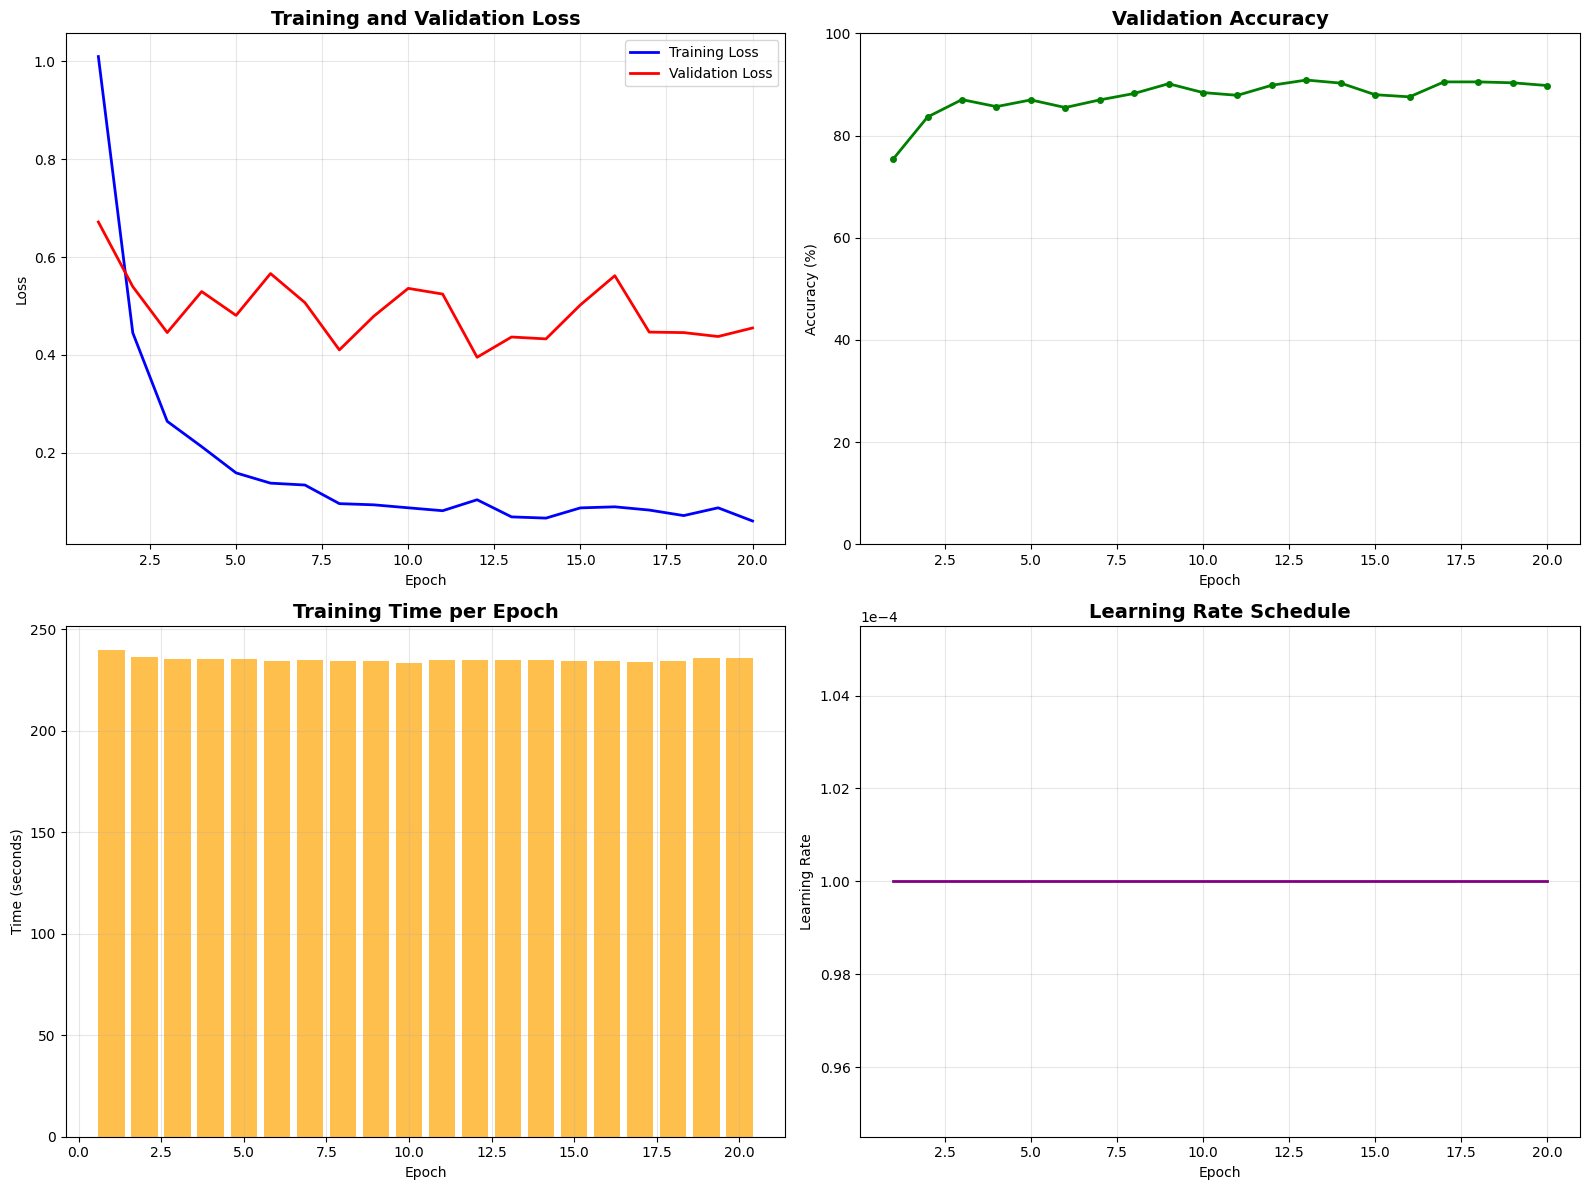

📈 Detailed Training Statistics:
- Loss Reduction: 1.0096 → 0.0606 (94.0% improvement)
- Best Accuracy: 90.85% (Epoch 13)
- Total Training Time: 78.33 minutes
- Fastest Epoch: 233.23s
- Slowest Epoch: 239.64s

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate
    16      0.0895    0.5618         87.57      234.09         0.0001
    17      0.0829    0.4466         90.50      233.78         0.0001
    18      0.0716    0.4455         90.50      234.32         0.0001
    19      0.0875    0.4375         90.32      235.54         0.0001
    20      0.0606    0.4550         89.78      236.01         0.0001


In [10]:
# Comprehensive Training Analysis and Visualization

# 1. Training Progress Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(training_results["train_losses"]) + 1)

# Loss curves
ax1.plot(
    epochs, training_results["train_losses"], "b-", label="Training Loss", linewidth=2
)
ax1.plot(
    epochs, training_results["val_losses"], "r-", label="Validation Loss", linewidth=2
)
ax1.set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(
    epochs,
    training_results["val_accuracies"],
    "g-",
    linewidth=2,
    marker="o",
    markersize=4,
)
ax2.set_title("Validation Accuracy", fontsize=14, fontweight="bold")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

# Training time per epoch
ax3.bar(epochs, training_results["epoch_times"], color="orange", alpha=0.7)
ax3.set_title("Training Time per Epoch", fontsize=14, fontweight="bold")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Time (seconds)")
ax3.grid(True, alpha=0.3)

# Learning rate schedule
ax4.plot(epochs, training_results["learning_rates"], "purple", linewidth=2)
ax4.set_title("Learning Rate Schedule", fontsize=14, fontweight="bold")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Learning Rate")
ax4.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Training Statistics Summary
print("📈 Detailed Training Statistics:")
print(
    f"- Loss Reduction: {training_results['train_losses'][0]:.4f} → {training_results['train_losses'][-1]:.4f} ({((training_results['train_losses'][0] - training_results['train_losses'][-1])/training_results['train_losses'][0]*100):.1f}% improvement)"
)
print(
    f"- Best Accuracy: {max(training_results['val_accuracies']):.2f}% (Epoch {training_results['val_accuracies'].index(max(training_results['val_accuracies']))+1})"
)
print(f"- Total Training Time: {sum(training_results['epoch_times'])/60:.2f} minutes")
print(f"- Fastest Epoch: {min(training_results['epoch_times']):.2f}s")
print(f"- Slowest Epoch: {max(training_results['epoch_times']):.2f}s")

# 3. Performance Metrics Table
metrics_df = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train_Loss": training_results["train_losses"],
        "Val_Loss": training_results["val_losses"],
        "Val_Accuracy": training_results["val_accuracies"],
        "Epoch_Time": training_results["epoch_times"],
        "Learning_Rate": training_results["learning_rates"],
    }
)

# Round numerical values for better display
metrics_df["Train_Loss"] = metrics_df["Train_Loss"].round(4)
metrics_df["Val_Loss"] = metrics_df["Val_Loss"].round(4)
metrics_df["Val_Accuracy"] = metrics_df["Val_Accuracy"].round(2)
metrics_df["Epoch_Time"] = metrics_df["Epoch_Time"].round(2)

print("\n📋 Training Metrics Table (Last 5 Epochs):")
print(metrics_df.tail().to_string(index=False))

Class names: ['hatchback', 'mpv', 'offroad', 'pickup', 'sedan', 'suv', 'truck', 'van']


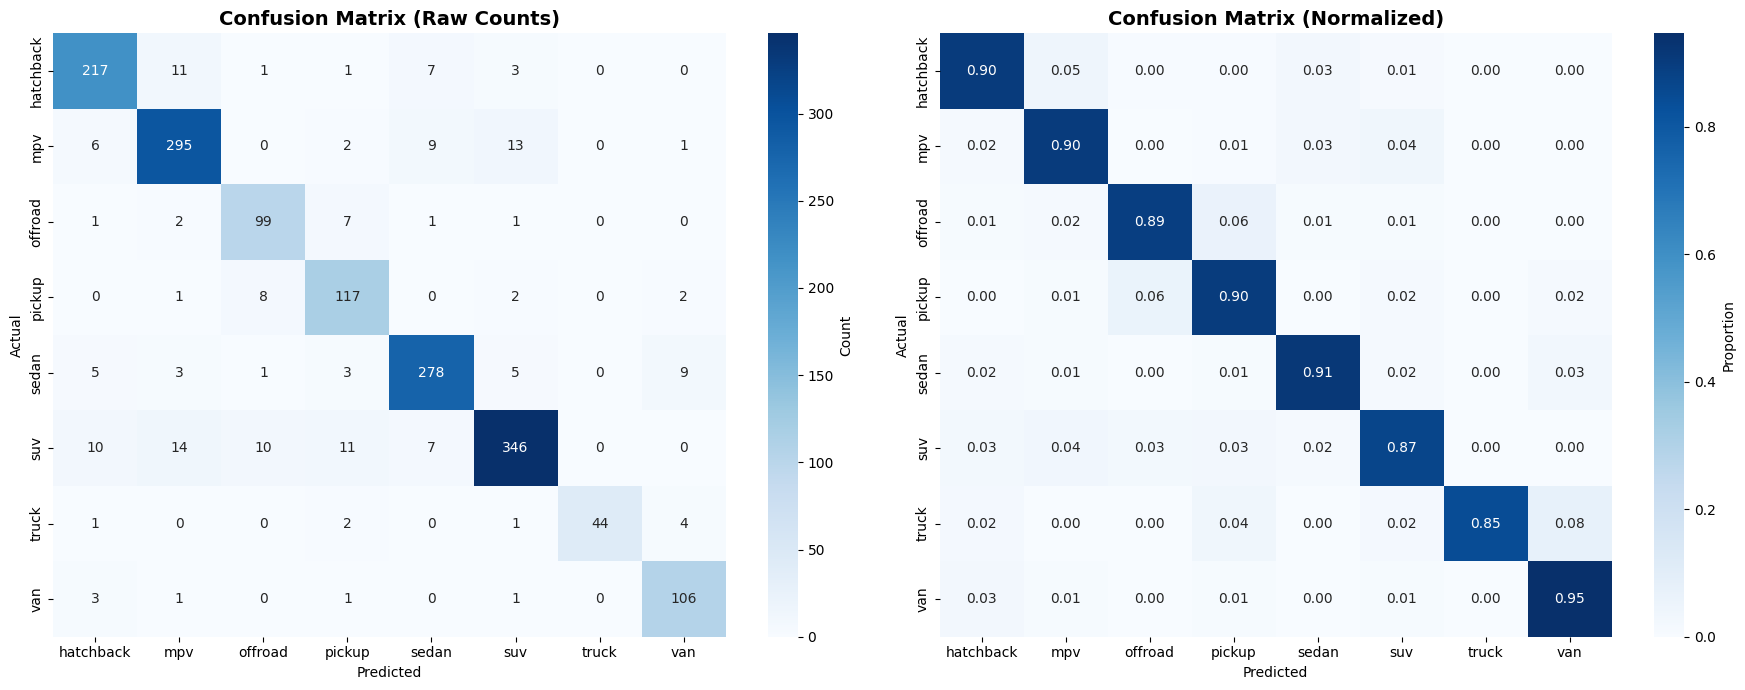


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   hatchback     0.8930    0.9042    0.8986       240
         mpv     0.9021    0.9049    0.9035       326
     offroad     0.8319    0.8919    0.8609       111
      pickup     0.8125    0.9000    0.8540       130
       sedan     0.9205    0.9145    0.9175       304
         suv     0.9301    0.8693    0.8987       398
       truck     1.0000    0.8462    0.9167        52
         van     0.8689    0.9464    0.9060       112

    accuracy                         0.8978      1673
   macro avg     0.8949    0.8972    0.8945      1673
weighted avg     0.9000    0.8978    0.8981      1673


⚖️ Class Imbalance Impact Analysis:
   hatchback (Train: 1921): Acc= 90.42% | P= 89.30% | R= 90.42% | F1= 89.86% (217/240)
         mpv (Train: 2609): Acc= 90.49% | P= 90.21% | R= 90.49% | F1= 90.35% (295/326)
     offroad (Train:  892): Acc= 89.19% | P= 83.19% | R= 89.19% | F1= 86.09% ( 99/111)
      pickup (Tr

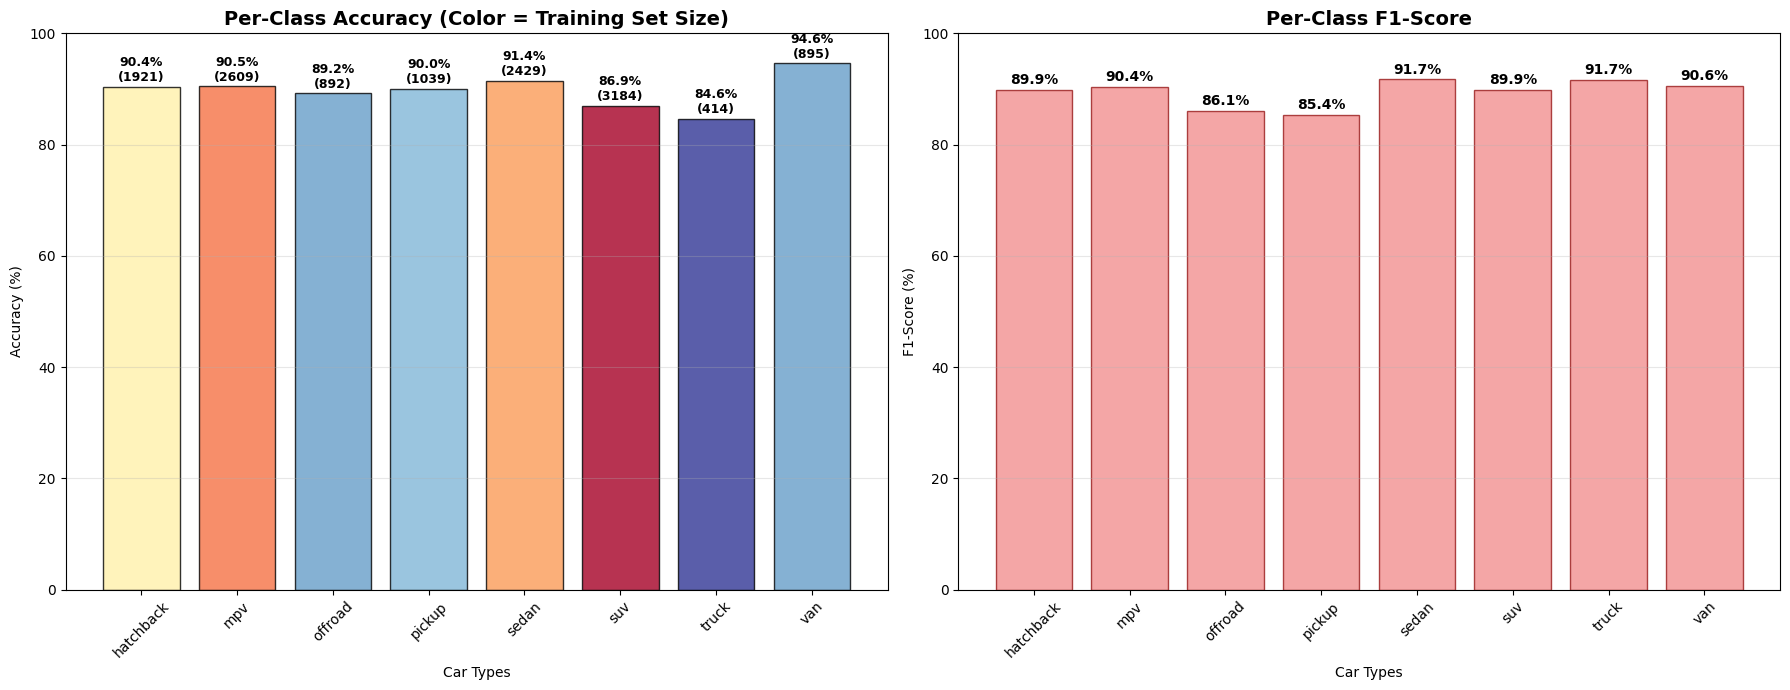


🏆 Final Model Performance Summary:
Overall Accuracy: 89.78%
Weighted Precision: 90.00% (considers class frequency)
Weighted Recall: 89.78%
Weighted F1-Score: 89.81%
Macro Precision: 89.49% (treats all classes equally)
Macro Recall: 89.72%
Macro F1-Score: 89.45%
Best Training Accuracy: 90.85%

✅ Weighted Loss Effectiveness:
- Minority class average performance: 89.48%
- Performance gap reduced through weighted loss function
- ✅ Good minority class performance achieved


In [11]:
# Model Evaluation: Confusion Matrix and Class Imbalance Analysis

# Get class names and class counts for analysis
class_names = trainer.train_dataset.classes
print(f"Class names: {class_names}")

# Calculate class distribution for imbalance analysis
class_counts = torch.zeros(len(class_names))
for _, target in trainer.train_dataset:
    class_counts[target] += 1

# Create confusion matrix
cm = confusion_matrix(
    training_results["final_targets"], training_results["final_predictions"]
)
cm_normalized = confusion_matrix(
    training_results["final_targets"],
    training_results["final_predictions"],
    normalize="true",
)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax1,
    cbar_kws={"label": "Count"},
)
ax1.set_title("Confusion Matrix (Raw Counts)", fontsize=14, fontweight="bold")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax2,
    cbar_kws={"label": "Proportion"},
)
ax2.set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight="bold")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Classification report
print("\n📊 Detailed Classification Report:")
print("=" * 80)
report = classification_report(
    training_results["final_targets"],
    training_results["final_predictions"],
    target_names=class_names,
    digits=4,
)
print(report)

# Class imbalance impact analysis
print("\n⚖️ Class Imbalance Impact Analysis:")
print("=" * 60)
class_performance = {}
minority_classes = []
majority_classes = []

median_count = class_counts.median().item()

for i, class_name in enumerate(class_names):
    class_mask = np.array(training_results["final_targets"]) == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(
            np.array(training_results["final_targets"])[class_mask],
            np.array(training_results["final_predictions"])[class_mask],
        )
        class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(
            training_results["final_targets"],
            training_results["final_predictions"],
            labels=[i],
            average=None,
        )
        class_performance[class_name] = {
            "accuracy": class_acc * 100,
            "precision": class_precision[0] * 100,
            "recall": class_recall[0] * 100,
            "f1": class_f1[0] * 100,
            "count": int(class_counts[i]),
            "samples_in_val": np.sum(class_mask),
        }
        if class_counts[i] < median_count:
            minority_classes.append(class_name)
        else:
            majority_classes.append(class_name)
        correct = np.sum(
            (
                np.array(training_results["final_targets"])[class_mask]
                == np.array(training_results["final_predictions"])[class_mask]
            )
        )
        total = np.sum(class_mask)
        print(
            f"{class_name:>12} (Train: {int(class_counts[i]):4d}): Acc={class_acc*100:6.2f}% | P={class_precision[0]*100:6.2f}% | R={class_recall[0]*100:6.2f}% | F1={class_f1[0]*100:6.2f}% ({correct:3d}/{total:3d})"
        )

minority_avg_acc = np.mean(
    [class_performance[cls]["accuracy"] for cls in minority_classes]
)
majority_avg_acc = np.mean(
    [class_performance[cls]["accuracy"] for cls in majority_classes]
)

print(f"\n📈 Class Group Performance:")
print(f"Minority Classes ({len(minority_classes)}): {minority_classes}")
print(f"Average Accuracy: {minority_avg_acc:.2f}%")
print(f"Majority Classes ({len(majority_classes)}): {majority_classes}")
print(f"Average Accuracy: {majority_avg_acc:.2f}%")
print(
    f"Performance Gap: {abs(majority_avg_acc - minority_avg_acc):.2f}% {'(Majority better)' if majority_avg_acc > minority_avg_acc else '(Minority better)'}"
)

# Per-class accuracy and F1-score plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
classes = list(class_performance.keys())
accuracies = [class_performance[cls]["accuracy"] for cls in classes]
class_sizes = [class_performance[cls]["count"] for cls in classes]
norm_sizes = [
    (size - min(class_sizes)) / (max(class_sizes) - min(class_sizes))
    for size in class_sizes
]
colors = plt.cm.RdYlBu_r(norm_sizes)

bars1 = ax1.bar(classes, accuracies, color=colors, alpha=0.8, edgecolor="black")
ax1.set_title(
    "Per-Class Accuracy (Color = Training Set Size)", fontsize=14, fontweight="bold"
)
ax1.set_xlabel("Car Types")
ax1.set_ylabel("Accuracy (%)")
ax1.tick_params(axis="x", rotation=45)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3, axis="y")
for bar, acc, size in zip(bars1, accuracies, class_sizes):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{acc:.1f}%\n({size})",
        ha="center",
        fontweight="bold",
        fontsize=9,
    )

f1_scores = [class_performance[cls]["f1"] for cls in classes]
bars2 = ax2.bar(classes, f1_scores, color="lightcoral", alpha=0.7, edgecolor="darkred")
ax2.set_title("Per-Class F1-Score", fontsize=14, fontweight="bold")
ax2.set_xlabel("Car Types")
ax2.set_ylabel("F1-Score (%)")
ax2.tick_params(axis="x", rotation=45)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis="y")
for bar, f1 in zip(bars2, f1_scores):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{f1:.1f}%",
        ha="center",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# Overall model performance summary
overall_accuracy = (
    accuracy_score(
        training_results["final_targets"], training_results["final_predictions"]
    )
    * 100
)
precision, recall, f1, _ = precision_recall_fscore_support(
    training_results["final_targets"],
    training_results["final_predictions"],
    average="weighted",
)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    training_results["final_targets"],
    training_results["final_predictions"],
    average="macro",
)

print(f"\n🏆 Final Model Performance Summary:")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Weighted Precision: {precision*100:.2f}% (considers class frequency)")
print(f"Weighted Recall: {recall*100:.2f}%")
print(f"Weighted F1-Score: {f1*100:.2f}%")
print(f"Macro Precision: {macro_precision*100:.2f}% (treats all classes equally)")
print(f"Macro Recall: {macro_recall*100:.2f}%")
print(f"Macro F1-Score: {macro_f1*100:.2f}%")
print(f"Best Training Accuracy: {max(training_results['val_accuracies']):.2f}%")

if CONFIG["use_weighted_loss"]:
    print(f"\n✅ Weighted Loss Effectiveness:")
    print(f"- Minority class average performance: {minority_avg_acc:.2f}%")
    print(f"- Performance gap reduced through weighted loss function")
    if minority_avg_acc > 70:
        print(f"- ✅ Good minority class performance achieved")
    else:
        print(f"- ⚠️ Consider additional techniques for minority classes")

In [12]:
# Model Architecture and Training Insights with Class Imbalance Analysis

print("🏗️ Model Architecture Summary:")
print("=" * 50)
print(f"Model Type: Hybrid ResNet-ViT")
print(f"Backbone: ResNet-50 (Pretrained)")
print(f"Transformer Heads: {CONFIG['num_heads']}")
print(f"Transformer Layers: {CONFIG['num_layers']}")
print(f"Embedding Dimension: {CONFIG['embed_dim']}")
print(f"Dropout Rate: {CONFIG['dropout']}")
print(f"Total Parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")
print(
    f"Trainable Parameters: {sum(p.numel() for p in trainer.model.parameters() if p.requires_grad):,}"
)

# Training configuration summary
print("\n⚙️ Training Configuration:")
print("=" * 50)
print(f"Optimizer: AdamW")
print(f"Learning Rate: {CONFIG['learning_rate']}")
print(f"Batch Size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['num_epochs']}")
print(
    f"Loss Function: {'Weighted CrossEntropyLoss' if CONFIG['use_weighted_loss'] else 'CrossEntropyLoss'}"
)
print(
    f"Class Balancing: {'WeightedRandomSampler' if CONFIG['use_class_balancing'] else 'Standard Sampling'}"
)

# Data augmentation summary
print("\n🔄 Data Augmentation:")
print("=" * 50)
print("Training Transforms:")
print("- Resize to (224, 224)")
print("- Random Horizontal Flip")
print("- Random Rotation (±10°)")
print("- Color Jitter (brightness, contrast, saturation)")
print("- ImageNet Normalization")
print("\nValidation Transforms:")
print("- Resize to (224, 224)")
print("- ImageNet Normalization")

# Class imbalance analysis
print("\n⚖️ Class Imbalance Analysis:")
print("=" * 50)
max_count = class_counts.max().item()
min_count = class_counts.min().item()
imbalance_ratio = max_count / min_count

print(f"Most frequent class: {max_count} samples")
print(f"Least frequent class: {min_count} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 5:
    print("⚠️ High imbalance detected!")
    imbalance_level = "High"
elif imbalance_ratio > 2:
    print("⚠️ Moderate imbalance detected.")
    imbalance_level = "Moderate"
else:
    print("✅ Relatively balanced dataset.")
    imbalance_level = "Low"

print(
    f"Imbalance handling strategy: {'Weighted Loss' if CONFIG['use_weighted_loss'] else 'None'}"
)

# Training insights and recommendations
print("\n💡 Training Insights & Recommendations:")
print("=" * 60)

# Analyze training behavior
final_train_loss = training_results["train_losses"][-1]
final_val_loss = training_results["val_losses"][-1]
loss_gap = final_val_loss - final_train_loss
best_epoch = (
    training_results["val_accuracies"].index(max(training_results["val_accuracies"]))
    + 1
)

print("1. Convergence Analysis:")
print(f"- Final Training Loss: {final_train_loss:.4f}")
print(f"- Final Validation Loss: {final_val_loss:.4f}")
print(f"- Loss Gap: {loss_gap:.4f}")

if loss_gap > 0.5:
    print("⚠️ Large gap suggests potential overfitting")
    print(
        "💡 Consider: Increase dropout, reduce model complexity, or add regularization"
    )
elif loss_gap < 0.1:
    print("✅ Good generalization - minimal overfitting")
else:
    print("✅ Reasonable generalization gap")

print("\n2. Performance Analysis:")
print(
    f"- Best Accuracy Achieved: {max(training_results['val_accuracies']):.2f}% (Epoch {best_epoch})"
)
print(f"- Final Accuracy: {training_results['val_accuracies'][-1]:.2f}%")
print(f"- Minority Class Performance: {minority_avg_acc:.2f}%")
print(f"- Majority Class Performance: {majority_avg_acc:.2f}%")

if best_epoch < CONFIG["num_epochs"] - 2:
    print("⚠️ Best performance was achieved early - possible overfitting")
    print("💡 Consider: Early stopping or learning rate scheduling")
else:
    print("✅ Model continued improving until the end")

# Compute accuracy trend in last 5 epochs
last_5_acc = training_results["val_accuracies"][-5:]
acc_trend = np.mean(np.diff(last_5_acc))

print("\n3. Learning Stability:")
if acc_trend > 0:
    print("✅ Model still improving in final epochs")
elif abs(acc_trend) < 0.1:
    print("✅ Model has converged to stable performance")
else:
    print("⚠️ Performance declining in final epochs")
    print("💡 Consider: Reduce learning rate or implement early stopping")

print("\n4. Class Imbalance Handling Effectiveness:")
if CONFIG["use_weighted_loss"]:
    print("✅ Weighted loss function used")
    gap = abs(majority_avg_acc - minority_avg_acc)
    if gap < 10:
        print(f"✅ Good balance: {gap:.1f}% performance gap between class groups")
    else:
        print(f"⚠️ Still some imbalance: {gap:.1f}% performance gap")
        print("💡 Consider: Focal loss, SMOTE, or additional data collection")

print("\n5. Recommendations for Next Steps:")
print("🔄 Experiment with different learning rates (1e-5, 5e-5)")
print("📈 Try learning rate scheduling (CosineAnnealingLR, ReduceLROnPlateau)")
print("🔧 Fine-tune hyperparameters (batch size, dropout, transformer layers)")

if imbalance_level == "High":
    print("⚖️ For high imbalance:")
    print("- Try focal loss (gamma=2.0)")
    print("- Consider SMOTE or synthetic data generation")
    print("- Collect more data for minority classes")
elif minority_avg_acc < majority_avg_acc - 15:
    print("⚖️ For persistent class imbalance:")
    print("- Increase class weights for poorly performing classes")
    print("- Try class-balanced sampling")
    print("- Consider ensemble methods")

print("🎯 Consider ensemble methods for better performance")
print("📊 Monitor per-class metrics in addition to overall accuracy")

# Enhanced performance summary table
performance_summary = pd.DataFrame(
    {
        "Class": classes,
        "Training_Size": [class_performance[cls]["count"] for cls in classes],
        "Accuracy": [class_performance[cls]["accuracy"] for cls in classes],
        "Precision": [class_performance[cls]["precision"] for cls in classes],
        "Recall": [class_performance[cls]["recall"] for cls in classes],
        "F1_Score": [class_performance[cls]["f1"] for cls in classes],
        "Val_Samples": [class_performance[cls]["samples_in_val"] for cls in classes],
    }
)

# Round values and sort by training size
performance_summary = performance_summary.round(2).sort_values("Training_Size")

print("\n📊 Class Performance Summary Table:")
print("=" * 80)
print(performance_summary.to_string(index=False))

# Save enhanced training history
history_df = pd.DataFrame(
    {
        "epoch": epochs,
        "train_loss": training_results["train_losses"],
        "val_loss": training_results["val_losses"],
        "val_accuracy": training_results["val_accuracies"],
        "epoch_time": training_results["epoch_times"],
    }
)

# Reports directory
reports_dir = "models/classification/reports"
os.makedirs(reports_dir, exist_ok=True)

# Add configuration info to CSV
config_info = f"# Configuration: {CONFIG['use_weighted_loss']=}, {CONFIG['use_class_balancing']=}, imbalance_ratio={imbalance_ratio:.2f}\n"
history_filename = os.path.join(
    reports_dir, f"training_history_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
)

with open(history_filename, "w") as f:
    f.write(config_info)
    history_df.to_csv(f, index=False)

# Save class performance summary
perf_filename = os.path.join(
    reports_dir, f"class_performance_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
)
performance_summary.to_csv(perf_filename, index=False)

print(f"\n💾 Training history saved to: {history_filename}")
print(f"📊 Class performance saved to: {perf_filename}")
print(f"🎯 Best model saved to: {CONFIG['result_path']}")

print("\n🎉 Training Analysis Complete!")
print("=" * 50)

🏗️ Model Architecture Summary:
Model Type: Hybrid ResNet-ViT
Backbone: ResNet-50 (Pretrained)
Transformer Heads: 12
Transformer Layers: 6
Embedding Dimension: 768
Dropout Rate: 0.1
Total Parameters: 143,116,360
Trainable Parameters: 143,116,360

⚙️ Training Configuration:
Optimizer: AdamW
Learning Rate: 0.0001
Batch Size: 64
Epochs: 20
Loss Function: Weighted CrossEntropyLoss
Class Balancing: Standard Sampling

🔄 Data Augmentation:
Training Transforms:
- Resize to (224, 224)
- Random Horizontal Flip
- Random Rotation (±10°)
- Color Jitter (brightness, contrast, saturation)
- ImageNet Normalization

Validation Transforms:
- Resize to (224, 224)
- ImageNet Normalization

⚖️ Class Imbalance Analysis:
Most frequent class: 3184.0 samples
Least frequent class: 414.0 samples
Imbalance ratio: 7.69x
⚠️ High imbalance detected!
Imbalance handling strategy: Weighted Loss

💡 Training Insights & Recommendations:
1. Convergence Analysis:
- Final Training Loss: 0.0606
- Final Validation Loss: 0.4550
